In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
from gurobipy import GRB, quicksum
import torch
import functools

import torch
from torch import nn
import torch.nn.functional as F
from copy import deepcopy

In [2]:
class QuadraticObj:
    
    def __init__(self, d=20, hidden_d=10):
        self.dim = d
        self.quadratic = np.random.randn(d,hidden_d)
        self.quadratic = np.matmul(self.quadratic, self.quadratic.T)
        self.linear = np.random.randn(d,1)
    
    def value_oracle(self, x):
        x_re = x.reshape(1,self.dim)
        obj = np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear)
        return obj[0][0]
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.reshape(1,self.dim) for x in x_list]
        value_list = [(np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear))[0][0] for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):   
        tensor_x = torch.tensor(x, requires_grad = True)
        x_re = tensor_x.reshape(1,self.dim)
        obj = torch.matmul(torch.matmul(x_re,torch.tensor(self.quadratic)), x_re.T) + torch.matmul(x_re, torch.tensor(self.linear))
        obj.backward()
        return tensor_x.grad.numpy()

    
    
class NonConvexObj:
    
    def __init__(self, d=20):
        self.dim = d
    
    def value_oracle(self, x):
        x_re = x.copy()
        obj = np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2)
        return obj
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.copy() for x in x_list]
        value_list = [np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2) for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):
        tensor_x = torch.tensor(x, requires_grad = True)
        obj = torch.sum(100 * ((tensor_x[1:] - (tensor_x[:-1] ** 2))**2) + (1-tensor_x[:-1]) ** 2)
        obj.backward()
        return tensor_x.grad.numpy()

# objective 

In [3]:
dim  = 100

In [4]:
#objective = QuadraticObj(d=dim,hidden_d=dim//2)
objective = NonConvexObj(d=dim)

In [5]:
initial = np.random.randn(objective.dim)
total_steps = 100
reps = 10
query_num = 10
lr = 1
mu = 0.1
top = 9

# optimization with gradient 

In [8]:
def optimize_with_gradient(objective, gradient_est_func, reps, lr, initial, total_steps):
    
    total_hist = []
    for _ in range(reps):
        x = initial.copy()
        state_dict = {}
        cur_obj = objective.value_oracle(x)
        hist= [cur_obj]
        for _ in range(total_steps):
            grad_est, state_dict = gradient_est_func(x, state_dict)
            x = x - lr * grad_est
            cur_obj = objective.value_oracle(x)
            hist.append(cur_obj)
        total_hist.append(hist)
    return total_hist

### Gradient Descent

In [7]:
def fo_grad_est(x, state_dict, objective):
    grad_est = objective.gradient_oracle(x)
    return grad_est / np.linalg.norm(grad_est), {}

gradient_est_func = functools.partial(fo_grad_est, objective = objective)
fo_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, lr, initial, total_steps)

### Gradient estimator with value oracle

In [ ]:
def zo_grad_est(x, state_dict, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        grad_est += (objective.value_oracle(x + mu * random_d) - cur_obj) * random_d / mu
    return grad_est / np.linalg.norm(grad_est), {}

gradient_est_func = functools.partial(zo_grad_est, objective = objective, query_num = query_num, mu = mu)
zo_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### Gradient estimator with comparison oracle (only work when top = query_num)

In [ ]:
def zo_comp_grad_est(x, state_dict, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        grad_est += np.sign(objective.value_oracle(x + mu * random_d) - cur_obj) * random_d 
    return grad_est / np.linalg.norm(grad_est), {}
        

gradient_est_func = functools.partial(zo_comp_grad_est, objective = objective, query_num = query_num, mu = mu)
zo_comp_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v1

In [ ]:
def zo_rank_v1_grad_est(x, state_dict, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    query_list = [x]
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
        
    grad_est = grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
    return grad_est, {}
        

gradient_est_func = functools.partial(zo_rank_v1_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v1_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v2 (only work when top = query_num)

In [ ]:
def zo_rank_v2_grad_est(x, state_dict, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
        weight = relative_rank - relative_rank[0]

        grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))],axis=0)
    
        return grad_est
    
    query_list = [x]
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
        
    return grad_est / np.linalg.norm(grad_est), state_dict
        
assert top == query_num
gradient_est_func = functools.partial(zo_rank_v2_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v2_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v3 (adding current best point)

In [ ]:
def zo_rank_v3_grad_est(x, state_dict, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    if "best_point" not in state_dict:
        state_dict["best_point"] = x.copy()
   
    best_point = state_dict["best_point"]
    
    query_list = [x]
    if np.linalg.norm(x - best_point) > 1e-4:
        query_list.append(best_point)
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
    state_dict["best_point"] = query_list[query_rank[0]]
        
    grad_est = grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
    return grad_est, state_dict

gradient_est_func = functools.partial(zo_rank_v3_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v3_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v4 (replace x with new random query)

In [ ]:
def zo_rank_v4_grad_est(x, state_dict, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    query_list = []
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
        
    grad_est = grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
    return grad_est, state_dict
        
best_point = initial.copy()
gradient_est_func = functools.partial(zo_rank_v4_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v4_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v5 (v1+v3+v4)

In [9]:
def zo_rank_v5_grad_est(x, state_dict, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    if "best_point" not in state_dict:
        state_dict["best_point"] = x.copy()
   
    best_point = state_dict["best_point"]
    
    query_list = [best_point]
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
    state_dict["best_point"] = query_list[query_rank[0]]
        
    grad_est = grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
    return grad_est, state_dict
        
gradient_est_func = functools.partial(zo_rank_v5_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v5_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

# optimization without gradient 

In [68]:
def optimize_without_gradient(objective, update_func, reps, initial, total_steps):
    total_hist = []
    global best_point
    for _ in range(reps):
        x = initial.copy()
        state_dict = {}
        cur_obj = objective.value_oracle(x)
        hist= [cur_obj]
        for s in range(total_steps):
            x, state_dict = update_func(x, state_dict)
            cur_obj = objective.value_oracle(x)
            hist.append(cur_obj)
            print("step:{}".format(s), objective.value_oracle(state_dict["best_point"]))
        total_hist.append(hist)
            
    return total_hist

### GLD

In [ ]:
def gld_update_func(x, state_dict, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    best_point = x.copy()
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_point = x + mu * random_d
        query_value = objective.value_oracle(query_point)
        if query_value < cur_obj:
            cur_obj = query_value
            best_point = query_point
        mu /= 2
    return best_point, state_dict

update_func = functools.partial(gld_update_func, objective = objective, query_num = query_num, mu = 0.4)
gld_total_hist = optimize_without_gradient(objective, update_func, reps, initial, total_steps)

### Heuristic v1

In [ ]:
def heuristic_update_func(x, state_dict, objective, query_num, mu, top):
    query_list = []
    for _ in range(query_num):
        random_d = np.random.randn(objective.dim)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    updated_point = np.zeros_like(x)
    acc_weight = 0
    for r, p in enumerate(query_rank):
        w = len(query_rank) - r
        acc_weight += w
        updated_point += w * query_list[p]
    updated_point /= acc_weight
    
    return updated_point, state_dict

update_func = functools.partial(heuristic_update_func, objective = objective, query_num = query_num, mu = 0.2, top = min([3,top]))
heuristic_total_hist = optimize_without_gradient(objective, update_func, reps, initial, total_steps)

### Heuristic v2 with progress monitoring

In [75]:
def heuristic_v2_update_func(x, state_dict, objective, query_num, mu, top):
    if "best_point" not in state_dict:
        state_dict["best_point"] = x.copy()
   
    best_point = state_dict["best_point"]
    
    query_list = [best_point]
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    updated_point = np.zeros_like(x)
    acc_weight = 0
    for r, p in enumerate(query_rank):
        w = len(query_rank) - r
        acc_weight += w
        updated_point += w * query_list[p]
    updated_point /= acc_weight
    
    state_dict["best_point"] = query_list[query_rank[0]]
    
    return updated_point, state_dict

update_func = functools.partial(heuristic_v2_update_func, objective = objective, query_num = query_num , mu = 0.2, top = min([3,top]))
heuristic_v2_total_hist = optimize_without_gradient(objective, update_func, 1, initial, total_steps)

step:0 74630.21368960713
step:1 65799.81040438206
step:2 63993.713611446896
step:3 57626.16546636683
step:4 55656.36668157165
step:5 48634.549259777195
step:6 45423.7371415325
step:7 45423.7371415325
step:8 42863.1558366233
step:9 38977.100917936084
step:10 38783.07155061571
step:11 34964.07803369842
step:12 34103.25408785876
step:13 32123.488713255232
step:14 30975.17962065146
step:15 28811.60988804431
step:16 28660.43695955846
step:17 26110.541842089395
step:18 22670.864642799206
step:19 22670.864642799206
step:20 21871.091417628275
step:21 21871.091417628275
step:22 20562.798860258692
step:23 20459.958133554283
step:24 18545.828986304747
step:25 18545.828986304747
step:26 17830.78605833956
step:27 17385.946997029918
step:28 16570.298011832758
step:29 15606.788815658423
step:30 14729.03040507387
step:31 14156.469619205545
step:32 13422.021202538428
step:33 12592.719458764514
step:34 11783.49381796202
step:35 10925.51054900848
step:36 10901.128862312478
step:37 10145.896603796735
step

### CMA-ES

In [ ]:
from cma import CMAEvolutionStrategy

es_total_hist = []
for _ in range(reps):
    es = CMAEvolutionStrategy(list(initial), mu, {'popsize':query_num})
    es_hist= []
    for _ in range(total_steps):
        solutions = es.ask()
        values = [objective.value_oracle(np.array(x)) for x in solutions]
        es_hist.append(np.min(values))
        es.tell(solutions, values)
    es_total_hist.append(es_hist)

# online optimization with rank model

### utils

In [39]:
class TopK_custom(torch.nn.Module):
    def __init__(self, k, device, epsilon=0.1, max_iter = 200):
        super(TopK_custom, self).__init__()
        self.k = k
        self.epsilon = epsilon
        self.anchors = torch.FloatTensor([i for i in range(k+1)]).view([1,1, k+1])#.to(device)
        self.max_iter = max_iter
        self.device = device
        

    def forward(self, scores):
        device = self.device
        
        bs, n = scores.size()
        scores = scores.view([bs, n, 1])
        
        #find the -inf value and replace it with the minimum value except -inf
        scores_ = scores.clone().detach()
        max_scores = torch.max(scores_).detach()
        scores_[scores_==float('-inf')] = float('inf')
        min_scores = torch.min(scores_).detach()
        filled_value = min_scores - (max_scores-min_scores)
        mask = scores==float('-inf')
        scores.masked_fill(mask, filled_value)
        
        C = (scores-self.anchors)**2
        C = C / (C.max().detach())
        
        mu = torch.ones([1, n, 1], requires_grad=False)#.to(device)
        nu = [1 for _ in range(self.k)]
        nu.append((n-self.k))
        nu = torch.FloatTensor(nu).view([1,1,self.k+1])#.to(device)

            
        Gamma = TopKFunc.apply(C, mu, nu, self.epsilon, self.max_iter)
        
        return Gamma.transpose(-1,-2)



class TopKFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, C, mu, nu, epsilon, max_iter):
        bs, n, k_ = C.size()
        device = C.get_device()
        with torch.no_grad():
            f = torch.zeros([bs, n, 1])#.to(device)
            g = torch.zeros([bs, 1, k_])#.to(device)
            Gamma_old = torch.exp((-C+f+g)/epsilon)
            
            def min_epsilon_row(Z, epsilon):
                return -epsilon*torch.logsumexp((-C+f+g)/epsilon, -1, keepdim=True)
            
            def min_epsilon_col(Z, epsilon):
                return -epsilon*torch.logsumexp((-C+f+g)/epsilon, -2, keepdim=True)
    
            for i in range(max_iter):
                
                f = min_epsilon_row(C-f-g, epsilon)+f+epsilon*torch.log(mu)
                g = min_epsilon_col(C-f-g, epsilon)+ g +epsilon*torch.log(nu)
                
                Gamma = torch.exp((-C+f+g)/epsilon)
                
                Gamma_diff = torch.norm((Gamma-Gamma_old) / bs / n/ k_,"fro")
#                 nu_cond = torch.norm((torch.matmul(Gamma.permute(0,2,1),mu[0,:,:]).permute(0,2,1) - nu) / bs,"fro")
#                 mu_cond = torch.norm((torch.matmul(Gamma,nu.view(k_,1)) - mu) / bs,"fro")
                

                if (Gamma_diff < 1e-5):
                    #print("stop at ",i," step")
                    break
                
                Gamma_old = Gamma
 
        
            ctx.save_for_backward(mu, nu, Gamma)
            ctx.epsilon = epsilon      
        return Gamma

    @staticmethod
    def backward(ctx, grad_output_Gamma):
        
        
        epsilon = ctx.epsilon
        mu, nu, Gamma = ctx.saved_tensors
        # mu [1, n, 1]
        # nu [1, 1, k+1]
        #Gamma [bs, n, k+1]
                  
        device = Gamma.get_device()
        with torch.no_grad():
            nu_ = nu[:,:,:-1]
            Gamma_ = Gamma[:,:,:-1]
    
            bs, n, k_ = Gamma.size()
            
            inv_mu = 1./(mu.view([1,-1]))  #[1, n]
            Kappa = torch.diag_embed(nu_.squeeze(-2)) \
                    -torch.matmul(Gamma_.transpose(-1, -2) * inv_mu.unsqueeze(-2), Gamma_)   #[bs, k, k]
            #print(Kappa, Gamma_)
            padding_value = 1e-10
            ridge = torch.ones([bs, k_-1]).diag_embed()#.to(device)
            inv_Kappa = torch.inverse(Kappa+ridge*padding_value) #[bs, k, k]
            #print(Kappa, inv_Kappa) 
            mu_Gamma_Kappa = (inv_mu.unsqueeze(-1)*Gamma_).matmul(inv_Kappa) #[bs, n, k]
            H1 = inv_mu.diag_embed() + mu_Gamma_Kappa.matmul(Gamma_.transpose(-1, -2))*inv_mu.unsqueeze(-2) #[bs, n, n]
            H2 = - mu_Gamma_Kappa  #[bs, n, k]
            H3 = H2.transpose(-1,-2) #[bs, k, n]
            H4 = inv_Kappa #[bs, k, k]
    
            H2_pad = F.pad(H2, pad=(0, 1), mode='constant', value=0) 
            H4_pad = F.pad(H4, pad=(0, 1), mode='constant', value=0)
            grad_f_C =  H1.unsqueeze(-1)*Gamma.unsqueeze(-3) \
                       + H2_pad.unsqueeze(-2)*Gamma.unsqueeze(-3) #[bs, n, n, k+1]
            grad_g_C =  H3.unsqueeze(-1)*Gamma.unsqueeze(-3) \
                       + H4_pad.unsqueeze(-2)*Gamma.unsqueeze(-3) #[bs, k, n, k+1]
    
            grad_g_C_pad = F.pad(grad_g_C, pad=(0, 0, 0, 0, 0, 1), mode='constant', value=0)
            grad_C1 = grad_output_Gamma * Gamma
            grad_C2 = torch.sum(grad_C1.view([bs, n, k_, 1, 1])*grad_f_C.unsqueeze(-3), dim=(1,2))
            grad_C3 = torch.sum(grad_C1.view([bs, n, k_, 1, 1])*grad_g_C_pad.unsqueeze(-4), dim=(1,2))
    
            grad_C = (-grad_C1+grad_C2+grad_C3)/epsilon
                   
        return grad_C, None, None, None, None
    
class Net_sigmoid(nn.Module):
    
    def __init__(self, dim):
        super(Net_sigmoid, self).__init__()
        # First fully connected layer
        self.dim = dim
        self.fc1 = nn.Linear(dim, 256)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        # Pass data through fc1
        bz, qn, dim = x.shape
        out = self.fc1(x.view(-1,dim))
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)

        # Apply softmax to x
        out = torch.sigmoid(out)
        return out.view(bz,-1)

### main function 

step:0 70104.39571101658


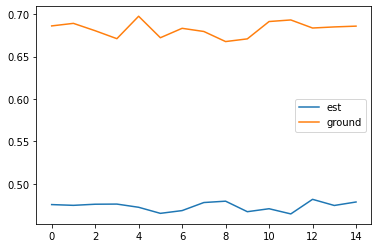

step:1 70104.39571101658


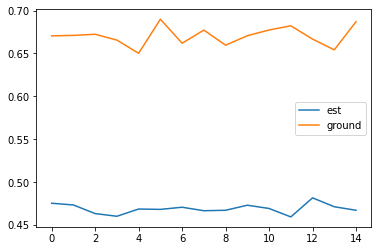

step:2 62003.19571517916


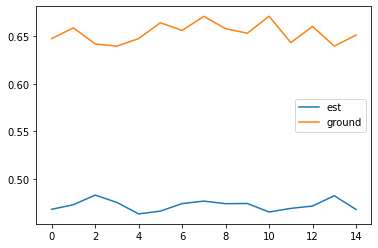

step:3 59062.365238875864


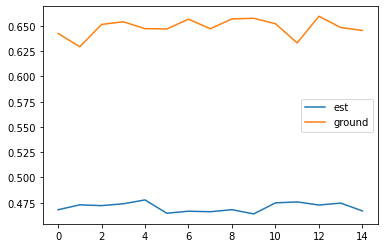

step:4 52965.48693376376


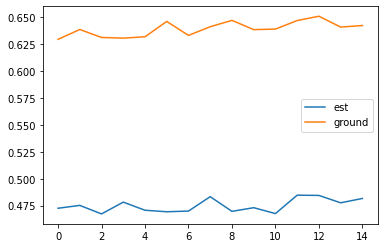

step:5 52965.48693376376


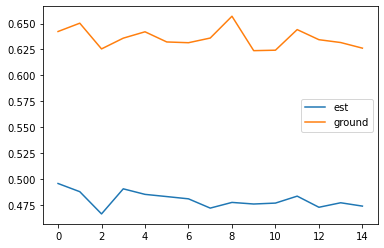

step:6 50583.42110483889


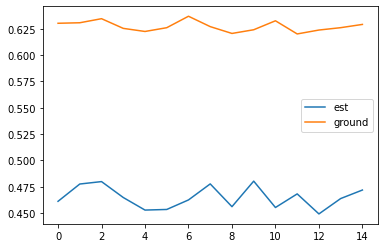

step:7 48957.48262816311


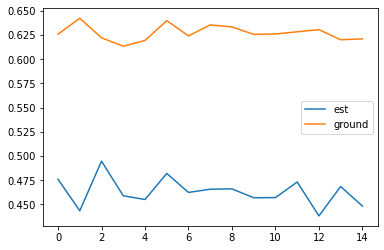

step:8 46174.990668460065


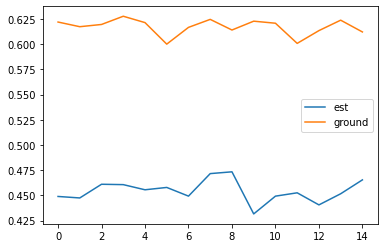

step:9 40543.9580259726


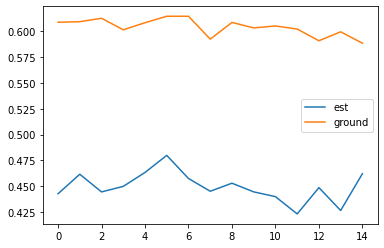

step:10 36762.64484462093


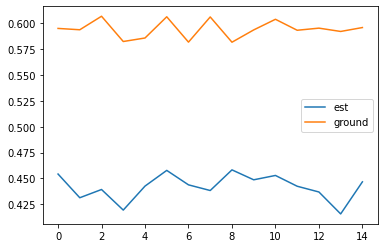

step:11 32976.295082515666


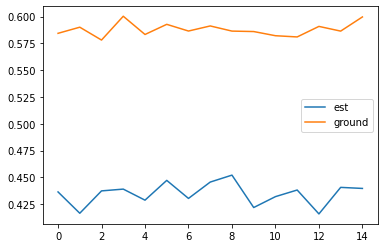

step:12 31515.456020903093


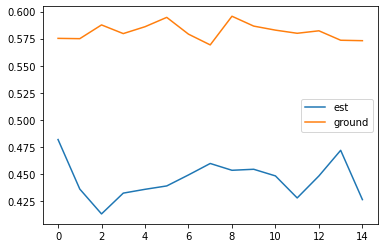

step:13 29437.349076412378


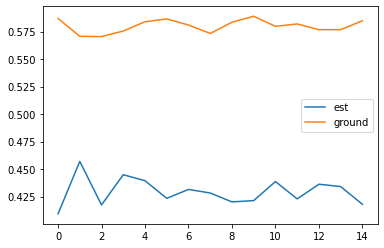

step:14 28344.39103649834


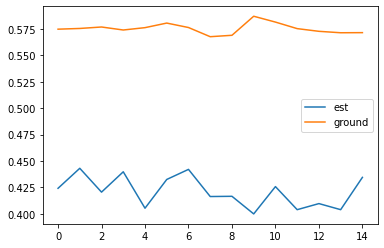

In [88]:
def check_test_acc(model,test_data):

    with torch.no_grad():
        est_test = model(test_data)
    acc = (est_test[:,0] < est_test[:,1]).sum() / est_test.shape[0]

    return acc.item() * 100

def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

def fit_rank(state_dict, epoch = 100, lr = 0.001, tol = 5, gpu = False):
    #print('fitting rank model')

    device = torch.device('cuda' if gpu else 'cpu')

    model = state_dict['rank_model']
    x_data = state_dict['train_x']
    perm_data = state_dict['train_perm']
    test_data = state_dict['test_data']

    data_len = len(x_data)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    loss_fn = torch.nn.MSELoss(reduction='mean')

    avg_loss = 0
    total_num = 0 
    
    best = 0
    no_improve_ep = 0
    best_model = deepcopy(model.state_dict())
    for ep in range(epoch):
        no_improve_ep += 1
        for batch_ind in index_iterator(data_len, 1):
            optimizer.zero_grad()
            scores = model(x_data[batch_ind[0]])
            ground_perm = perm_data[batch_ind[0]]

            soft_sorted_topk = TopK_custom(ground_perm.shape[1] - 1, device, epsilon=0.01, max_iter = 200)

            perm_mat = soft_sorted_topk(scores)
            loss = loss_fn(perm_mat, ground_perm)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            total_num += 1
            
        acc = check_test_acc(model, test_data)
        
        
        
        #print(ep,avg_loss/total_num,acc)
            
        if acc > best:
            best = acc
            no_improve_ep = 0
            best_model = deepcopy(model.state_dict())
            
        if no_improve_ep > tol:
            break

    #print("best acc", best)
    model.load_state_dict(best_model)


def generate_query_from_rank_model(x, state_dict, query_num, mu, num_candidates = 15, normalized = True):
    if "best_point" not in state_dict:
        state_dict["best_point"] = x.copy()
   
    best_point = state_dict["best_point"]
    query_list = [best_point]
    dim = x.shape[0]
    
    if "rank_model" not in state_dict:
        for _ in range(query_num - len(query_list)):
            random_d = np.random.randn(dim)
            if normalized:
                random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
    else:
        model = state_dict["rank_model"]
        candidates_direction = np.random.randn(num_candidates, dim)
        if normalized:
            candidates_direction /= np.linalg.norm(candidates_direction, axis=-1, keepdims=True)
        candidates_solution = x.reshape(1,-1) + mu * candidates_direction
        candidates_score = model(torch.FloatTensor(candidates_solution).unsqueeze(0)).flatten()
        top_candidates = candidates_solution[torch.argsort(candidates_score)[:query_num],:]
        query_list.extend([q for q in top_candidates])

        plt.plot(candidates_score.detach().numpy(),label="est")
        plt.plot([1/(1+np.exp(-objective.value_oracle(cs)/100000)) for cs in candidates_solution],label="ground")
        plt.legend()
        plt.show()
    
    return query_list
   
def constuct_perm(rank_data, query_num):

    perm_mat = np.zeros((len(rank_data) + 1, query_num))
    for jj in range(query_num):
        if jj in rank_data:
            now_ind = np.where(rank_data == jj)[0][0]
            perm_mat[now_ind,jj] = 1
        else:
            perm_mat[len(rank_data),jj] = 1
    
    return torch.FloatTensor(perm_mat[np.newaxis,...])  
    
def construct_train_test_data(query_list, query_rank, whether_to_select_test_data):
    test_data = []
    if whether_to_select_test_data:
        select_num = min([1,round(0.1 * len(query_list))])
        select_test_ind = np.random.choice(np.arange(len(query_list)),select_num,replace=False)
        worst_inds = [ind for ind in range(len(query_list)) if ind not in query_rank]
    else:
        select_test_ind = []
        
    for st_ind in select_test_ind:
        if st_ind in query_rank:
            for w_ind in worst_inds:
                test_data.append((query_list[st_ind],query_list[w_ind]))

        reverse = False
        for q_ind in query_rank:

            if q_ind == st_ind:
                reverse = True
                continue

            if reverse:
                test_data.append((query_list[st_ind], query_list[q_ind]))
            else:
                test_data.append((query_list[q_ind], query_list[st_ind]))

    if len(test_data) > 0:
        test_data = torch.FloatTensor(np.array(test_data))

    modified_query_rank = [q_ind - len([s_ind for s_ind in select_test_ind if s_ind < q_ind]) for q_ind in query_rank if q_ind not in select_test_ind]
    modified_query_rank = np.array(modified_query_rank)
    
    train_data = np.array([p for p_ind, p in enumerate(query_list) if p_ind not in select_test_ind])
    train_data = torch.FloatTensor(train_data).unsqueeze(0)
    train_perm = constuct_perm(modified_query_rank, len(query_list) - len(select_test_ind))

    # debug
    #print(query_rank, modified_query_rank, select_test_ind, train_data.shape, train_perm.shape, len(test_data))
    
    return train_data, train_perm, test_data
      
        
def update_data_and_rank_model(state_dict, query_list, query_rank):
    # construct train test data
    if "train_x" not in state_dict:
        train_x, train_perm, test_data = construct_train_test_data(query_list, query_rank, True)
        state_dict["train_x"] = [train_x]
        state_dict["train_perm"] = [train_perm]
        state_dict["test_data"] = test_data
    else:
        whether_to_select_test_data = np.random.randint(2)
        train_x, train_perm, test_data = construct_train_test_data(query_list, query_rank, whether_to_select_test_data)
        state_dict["train_x"].append(train_x)
        state_dict["train_perm"].append(train_perm)
        if whether_to_select_test_data:
            state_dict["test_data"] = torch.concat([state_dict["test_data"], test_data])
        
    # fit rank model
    if "rank_model" not in state_dict:
        state_dict["rank_model"] = Net_sigmoid(query_list[0].shape[-1])

    fit_rank(state_dict, epoch = 10, lr = 0.0001, tol = 5)
    
    return state_dict



# debug 

def heuristic_v2_with_rank_model_update_func(x, state_dict, objective, query_num, mu, top):
    
    query_list = generate_query_from_rank_model(x, state_dict, query_num, mu, normalized = False)
    
    query_rank = objective.rank_oracle(query_list, top)
    updated_point = np.zeros_like(x)
    acc_weight = 0
    for r, p in enumerate(query_rank):
        w = len(query_rank) - r
        acc_weight += w
        updated_point += w * query_list[p]
    updated_point /= acc_weight
    
    state_dict["best_point"] = query_list[query_rank[0]]
    
    state_dict = update_data_and_rank_model(state_dict, query_list, query_rank)
    
    return updated_point, state_dict

update_func = functools.partial(heuristic_v2_with_rank_model_update_func, objective = objective, query_num = query_num, mu = 0.2, top = min([3,top]))
heuristic_v2_with_rank_model_total_hist = optimize_without_gradient(objective, update_func, 1, initial, total_steps)

### rank-based  gradient estimator v5 + rank model

array([1, 2])

### Heuristic v2 + rank model

In [12]:
def heuristic_v2_with_rank_model_update_func(x, state_dict, objective, query_num, mu, top):
    
    query_list = generate_query_from_rank_model(x, state_dict, query_num, mu, normalized = False)
    
    query_rank = objective.rank_oracle(query_list, top)
    updated_point = np.zeros_like(x)
    acc_weight = 0
    for r, p in enumerate(query_rank):
        w = len(query_rank) - r
        acc_weight += w
        updated_point += w * query_list[p]
    updated_point /= acc_weight
    
    state_dict["best_point"] = query_list[query_rank[0]]
    
    state_dict = update_data_and_rank_model(state_dict, query_list, query_rank)
    
    return updated_point, state_dict

update_func = functools.partial(heuristic_v2_with_rank_model_update_func, objective = objective, query_num = query_num, mu = 0.2, top = min([3,top]))
heuristic_v2_with_rank_model_total_hist = optimize_without_gradient(objective, update_func, reps, initial, total_steps)

# plot

In [13]:
def plot_hist(total_hist, label):
    total_hist = np.array(total_hist)
    total_mean = total_hist.mean(0)
    total_std = total_hist.std(0)
    plt.plot(total_mean,"--", label = label)
    total_steps = np.arange(len(total_mean))
    plt.fill_between(total_steps,total_mean - total_std,total_mean + total_std, alpha=0.3)

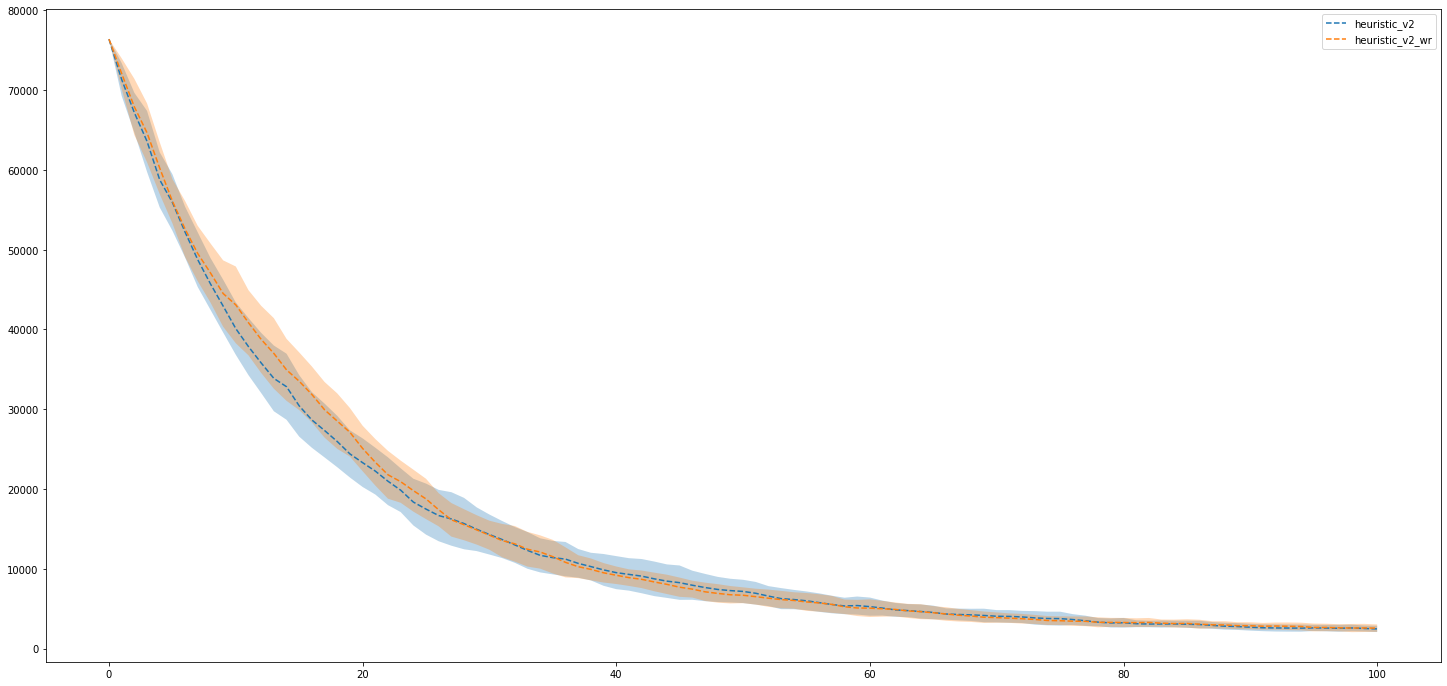

In [16]:
plt.figure(figsize=(25,12))

# plot_hist(fo_total_hist,"fo")
# plot_hist(zo_total_hist,"zo")
# plot_hist(zo_comp_total_hist,"zo_comp")
# plot_hist(zo_rank_v1_total_hist,"zo_rank_v1")
# plot_hist(zo_rank_v2_total_hist,"zo_rank_v2")
# plot_hist(zo_rank_v3_total_hist,"zo_rank_v3")
# plot_hist(zo_rank_v4_total_hist,"zo_rank_v4")
# plot_hist(zo_rank_v5_total_hist,"zo_rank_v5")

# plot_hist(gld_total_hist,"GLD")
#plot_hist(heuristic_total_hist,"heuristic")
plot_hist(heuristic_v2_total_hist,"heuristic_v2")
#plot_hist(es_total_hist,"CMA-ES")

plot_hist(heuristic_v2_with_rank_model_total_hist,"heuristic_v2_wr")

plt.legend()